In [1]:
import xgboost as xgb
from sklearn.datasets import load_svmlight_file

#  This script demonstrate how to do ranking with XGBRanker
x_train, y_train = load_svmlight_file("mq2008.train")
x_valid, y_valid = load_svmlight_file("mq2008.vali")
x_test, y_test = load_svmlight_file("mq2008.test")

display(x_train)

group_train = []
with open("mq2008.train.group", "r") as f:
    data = f.readlines()
    for line in data:
        group_train.append(int(line.split("\n")[0]))

group_valid = []
with open("mq2008.vali.group", "r") as f:
    data = f.readlines()
    for line in data:
#         print(line)
        group_valid.append(int(line.split("\n")[0]))

params = {'objective': 'rank:ndcg', 'learning_rate': 0.1,
          'gamma': 1.0, 'min_child_weight': 0.1,
          'max_depth': 6, 'n_estimators': 4}



# model = xgb.sklearn.XGBRanker(**params)
# model.fit(x_train, y_train, group_train, 
#           verbose=True,
#           eval_set=[(x_valid, y_valid)], 
#           eval_group=[group_valid])

model2 = xgb.sklearn.XGBRanker(**params)
model2.fit(x_train, y_train, group_train, 
          verbose = True)

# pred = model.predict(x_test)

pred2 = model2.predict(x_test)

# print(pred)
print(pred2)

<9630x46 sparse matrix of type '<class 'numpy.float64'>'
	with 233775 stored elements in Compressed Sparse Row format>

[0.7889732  0.17356828 0.7881559  ... 0.38062713 0.42701083 0.17356828]


In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split

df = pd.read_pickle("../pickles/df_small_clean.pkl")

df = df.drop(columns=['PriceBand'])
display(df.describe())

,prop_id,srch_id,position,price_quality,competitor_bool,availability_bools,visited_before,click_bool,booking_bool,promotion_flag,prop_brand_bool,random_bool,prop_location_score1,prop_location_score2,importance
count,49335.000000,49335.000000,49335.000000,49335.000000,49335.000000,49335.000000,49335.000000,49335.000000,49335.000000,49335.000000,49335.000000,49335.000000,49335.000000,49335.000000,49335.000000
mean,70233.165501,164188.521577,16.837235,91.824185,0.162684,0.095368,0.041776,0.044532,0.027668,0.211250,0.634053,0.297902,2.843792,0.126832,0.155204
std,40668.580445,94670.449020,10.429717,1517.174629,0.369081,0.293726,0.200078,0.206277,0.164021,0.408199,0.481700,0.457341,1.526112,0.138302,0.827339
min,1.000000,124.000000,1.000000,2.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35122.000000,85522.000000,8.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.790000,0.028300,0.000000
50%,70065.000000,163166.000000,16.000000,39.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.770000,0.113400,0.000000
75%,105183.000000,242490.000000,26.000000,53.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.970000,0.134350,0.000000
max,140816.000000,332740.000000,39.000000,110931.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.980000,1.000000,5.000000


In [23]:
testdf = df.copy()

df.drop(columns=["click_bool", "booking_bool", "position", "prop_id", "srch_id"])

x_train, x_test, y_train, y_test = train_test_split(df, df["importance"], test_size=0.2, random_state=42)

query_lengths = []
    
[query_lengths.append(len(group)) for srchid, group in x_train.groupby('srch_id')]

params = {'objective': 'rank:ndcg', 'learning_rate': 0.1,
          'gamma': 1.0, 'min_child_weight': 0.1,
          'max_depth': 10, 'n_estimators': 100}


groups = df.columns

model = xgb.sklearn.XGBRanker(**params, verbosity=0)
model.fit(x_train, y_train, query_lengths, verbose=True)

pred = model.predict(x_test)

[-6.18625   -4.6498985 -7.2287784 ... -6.1937833 -6.1937833 -6.0468907]
hoi 9867
9867
Index(['prop_id', 'srch_id', 'position', 'price_quality', 'competitor_bool',
       'availability_bools', 'visited_before', 'click_bool', 'booking_bool',
       'promotion_flag', 'prop_brand_bool', 'random_bool',
       'prop_location_score1', 'prop_location_score2', 'importance', 'rank'],
      dtype='object')


c:\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,prop_id,srch_id,position,price_quality,competitor_bool,availability_bools,visited_before,click_bool,booking_bool,promotion_flag,prop_brand_bool,random_bool,prop_location_score1,prop_location_score2,importance,rank
841636,68574,56240,9,23.500000,0,0,0,0,0,0,1,0,2.83,0.044500,0,-6.186250
4266389,40937,286375,15,30.000000,0,0,0,0,0,0,1,0,1.39,0.009600,0,-4.649899
3878201,30256,260289,7,21.333333,0,0,0,0,0,0,1,0,1.10,0.126832,0,-7.228778
3853352,17734,258648,1,23.002500,1,0,0,0,0,1,0,1,4.32,0.159000,0,-7.228778
4811171,105604,322836,22,34.000000,0,0,0,0,0,0,1,0,0.00,0.013200,0,-2.153689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2814872,31977,189021,4,46.000000,0,1,0,0,0,1,0,0,2.20,0.075400,0,-7.228778
3464976,77643,232671,29,35.666667,0,0,0,0,0,0,0,0,4.51,0.651700,0,2.763560
2041493,20813,137042,12,42.090000,0,0,0,0,0,0,1,0,0.69,0.019300,0,-6.193783
1792550,46004,120415,12,32.500000,1,0,0,0,0,0,0,0,2.89,0.109200,0,-6.193783


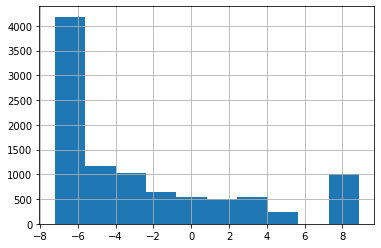

In [13]:
print(pred)

x_test["rank"] = pred
print("hoi", len(pred))
print(len(x_test))

print(x_test.columns)
display(x_test)

x_test["rank"].hist()

In [ ]:
model = xgb.XGBRanker(max_depth=10, learning_rate=0.1, n_estimators=1000, verbosity=1, objective='rank:ndcg', booster='gbtree', seed=1)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import datetime
import csv

df = pd.read_csv('training_set_VU_DM.csv')

# i = 0
# iteration = 1
# for chunk in pd.read_csv('training_set_VU_DM.csv', chunksize=4000):
#     df = chunk
#     i = i + 1
#     if i == iteration:
#         break

variable_list = ['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv',
       'comp8_rate_percent_diff', 'gross_bookings_usd','click_bool',
       'booking_bool']

def thing(df, variable_list):
    values_per_search = np.full([len(df.index), len(variable_list)], 0.5)
    target_per_search = []
    id_per_search = []
    time_list = []
    group_list = []
    current_idd = 0
    prev_id = 1
    i = 0
    
    for option in df.iterrows():
        i = i + 1
        if i % 250000 == 0:
            print(i)

        time_list.append(option[1]['date_time'])
        for j in range(2, len(variable_list)):

            values_per_search[i - 1][j - 2] = option[1][variable_list[j]]

        if option[1][variable_list[len(variable_list) - 1]] == 1:
            target_per_search.append(5)
        elif option[1][variable_list[len(variable_list) - 2]] == 1:
            target_per_search.append(1)
        else:
            target_per_search.append(0)

        id_per_search.append(option[1][variable_list[0]])
        
        if i > 2 and id_per_search[-1] != id_per_search[-2]:
            group_list.append(current_idd)
            current_idd = 0
        current_idd = current_idd + 1
    group_list.append(current_idd)

    return values_per_search, target_per_search, id_per_search, group_list, time_list

values_per_search, target_per_search, id_per_search, group_list, time_list = thing(df, variable_list)
print(values_per_search[0])
output = open('total_train.pkl', 'wb')
pickle.dump([values_per_search, target_per_search, id_per_search, group_list, time_list], output)
output.close()

# pkl_file = open('data_first_train_2500000.pkl', 'rb')
# values_per_search, target_per_search, id_per_search, group_list = pickle.load(pkl_file)
# pkl_file.close()